#### Ahora mismo:
- Modularizar GradCAM
- Implementación de GradCAM++
- Tratamiento de BBDD
- Índice de la memoria + parte teórica

#### Pasos siguientes:
- Implementación de SmoothGradCAM++
- Entrenamiento de los clasificadores en BBDD-tratado
- Explicación con CAM, GradCAM, GradCAM++ y SmoothGradCAM++ con los modelos entrenados
- Análisis de resultados

#### Hecho:
- Modularizar CAM
- Implementación CAM y gradCAM
- Selección de clasificadores (torch.models) (VGG, ResNet, Inception, MobileNet)

#### Dudas para siguiente sesión:
- Las capas totalmente conectadas no las he podido ir reduciendo en potencias de 2 porque excedía la memoria de la GPU.
- GradCAM lleva una capa ReLU para dar el saliency map. ¿Es buena idea ponérselo también a CAM?
- Paper de GradCAM++. En la computación de derivadas. Dice de coger la penúltima capa S^c y pone el supuesto caso de que la última capa sea lineal o relu. 
    - **QUÉ ENTIENDO YO**: si cogiésemos la penúltima capa, no se podría coger respecto de la clase c, porque eso solo lo tiene la última capa (tiene tantas salidas como números de clases) y al ser fully connected no tiene sentido. Por lo tanto, creo que se refiere a que cojamos nuestra última capa S^c, le pasemos una exponencial y luego una relu.
    - **PROBLEMA**: al hacer las derivadas, da por supuesto que la relu() va antes de la exponencial cuando al principio dice que pasamos la exponencial a los valores de la penúltima capa S^c. Si la última capa fuera relu no tendría sentido alguno porque la exponencial es siempre positiva entonces quedaría invariante. 
    - **QUÉ CREO QUE HACE**: creo que a la salida original le pasa una ReLU, y a eso ya le aplica una exponencial/softmax.
    - **CONCLUSIÓN SACADA**: al modelo con las nuevas FC le metemos al final una relu antes del softmax y podemos usar eso.

In [13]:
from torch.nn.modules.pooling import AdaptiveAvgPool2d
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor, Lambda
import torchvision.models as models
import torchvision

import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt
import numpy as np

import os

import time
import os
import copy
import math

import cv2


# Reset CUDA cache
torch.cuda.empty_cache()


## FUNCIONES ÚTILES GENERALES

In [14]:
def remove_modules_type(module, types_module):
    """
    Parameters:
    -----------
    module: nn.Module
      Module where we want to remove {type_module} modules.

    types_module: list of class which inherits from nn.Module
      Types to remove.

    Description:
    ------------
    This function remove all {type_module} modules from
    a first module: {module}

    Return:
    -------
    List of nn.Module
    """
    presence_type = False
    mod_without_type = []
    out_channels = -1
    
    # Prueba:
    in_features_channels = []  # input of the module we are removing
    
    for m in module.children():
        # Test the type
        for type_module in types_module:
            if isinstance(m, type_module) and not presence_type:
                presence_type = True
                try:
                    # If it's Linear
                    in_features_channels.append(m.in_features)
                except:
                    try:
                        # If it's Conv2d
                        in_features_channels.append(m.in_channels)
                    except:
                        # Other cases are not considered
                        in_features_channels = in_features_channels

                break

        if presence_type:
            return mod_without_type, in_features_channels
        
        elif isinstance(m, nn.Sequential):
            # If it's sequential
            modules_removed, in_features_channels_new = remove_modules_type(m, [nn.Linear])
            in_features_channels = in_features_channels + in_features_channels_new

            if len(modules_removed)>0:
                mod_without_type.append(nn.Sequential(*modules_removed))
        else:
            mod_without_type.append(m)
            

    return mod_without_type, in_features_channels


############################################################################
# ENTRENAMIENTO
############################################################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=2, device='cuda'):
    since = time.time()

    # Saving actual weights as best weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = math.inf
    best_acc = 0.

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                if i % 200 == 199:
                    print('[%d, %d] loss: %.3f' %(epoch + 1, i, running_loss / (i * inputs.size(0))))

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                scheduler.step()
            elif phase == 'val' and epoch_loss < best_loss:
                # deep copy the model
                print(f'New best model found!')
                print(f'New record loss: {epoch_loss}, previous record loss: {best_loss}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, best_loss, best_acc




############################################################################
# PLOT
############################################################################
def plot_saliency_map(model, x, y, class_plot=-1, device='cuda'):
    """
    Parameters:
    -----------
        - model: model
        
        - x: input

        - y: {x} actual class

        - class_plot:
                {-2} to plot all classes
                {-1} to plot the class predicted
                {n}  to plot the n-class (n in {0,1,2,...})
    """
    # utils
    soft = nn.Softmax(dim=1)

    # Taking the class predicted
    y_pred_modnew = torch.argmax(soft(model(x)),axis=1)

    # Getting the heatmaps
    heatmaps_pre = model.saliency_map(x, device)

    heatmaps_new = list()
    # Visualización
    for hm in heatmaps_pre:
        heatmaps_new.append(hm.cpu().detach().numpy())
        print(hm.size())

    res0 = cv2.resize(heatmaps_new[0]*225, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    res1 = cv2.resize(heatmaps_new[1]*225, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)


    ###########################
    #   HACEMOS PLOT
    if (y_pred_modnew==0 and class_plot==-1) or class_plot==0 or class_plot==-2:

        # CAM-new
        fig, axes = plt.subplots(nrows=1, ncols=1)

        axes.imshow(x_plot)
        axes.imshow(res0,alpha=0.5, cmap=plt.get_cmap('seismic'))
        axes.title.set_text(f"----------- HEATMAP DE GATO -----------")

        plt.show()

    if (y_pred_modnew==1 and class_plot==-1) or class_plot==1 or class_plot==-2:

        # CAM-new
        fig, axes = plt.subplots(nrows=1, ncols=1)

        axes.imshow(x_plot)
        axes.imshow(res1,alpha=0.5, cmap=plt.get_cmap('seismic'))
        axes.title.set_text(f"----------- HEATMAP DE PERRO -----------")

        plt.show()

In [15]:
model_vgg = models.vgg16(pretrained=True)
print(model_vgg)



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## PRUEBA DE CAPAS

In [16]:
# With default parameters
flat = nn.Flatten()

# pool of non-square window
m = nn.AdaptiveAvgPool2d(output_size=(1))
lin = nn.Linear(in_features=512, out_features = 4096, bias = True)
mm = nn.AvgPool2d(20)
l=[]
for i in range(20):
  row=[]
  for j in range(20):
    row.append(float(20*i+j))
  l.append(row)


arr=np.array([l])
input = torch.from_numpy(arr)
input = torch.rand(512,30,30)
input = torch.randn(32, 1, 5, 5)

"""
# Ejecutamos los pooling
output = m(input)
print(f"tensor:\n {output}\n\nOutput shape: {output.shape}")
output2 = lin(torch.reshape(output, (1,25088)))
print(f"tensor:\n {output2}\n\nOutput shape: {output2.shape}")
"""
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x7 and 25088x4096)

output = m(input)
output_flat = flat(output)

sh = output.shape
#print(f"tensor:\n {output}\n\nOutput shape: {output.shape}, {output_flat.shape}")
#print((torch.reshape(output,(sh[0],sh[1]))==output_flat).all())


## CLASES CAM

In [17]:
class CAM_model(nn.Module):
    def __init__(self, originalModel, D_out):
        super(CAM_model, self).__init__()
        # Quitamos la FC
        fc_removed, in_features = remove_modules_type(originalModel, [nn.Linear])
        self.list_modules = nn.ModuleList(fc_removed)
        self.avgPool_CAM = nn.AdaptiveAvgPool2d(output_size=(1))

        self.fc = nn.Linear(in_features=in_features[-1], out_features=D_out, bias=False)
        self.n_classes = D_out


    def forward(self, x):
        # utils
        flat = nn.Flatten()

        # forward
        x_mod = x
        for mod in self.list_modules:
            x_mod = mod(x_mod)
        x_mod = self.avgPool_CAM(x_mod) 
        x_mod = flat(x_mod) # flatten
        x_mod = self.fc(x_mod)

        return x_mod

    def saliency_map(self, x, device='cuda'):
        # utils
        soft = nn.Softmax(dim=1)

        # Evaluate mode
        self.eval()
        y_pred = torch.argmax(soft(self(x)),axis=1)

        # We generate the activation map
        x_mod = x
        for mod in self.list_modules:
            x_mod = mod(x_mod)
        features = x_mod[0]

        heatmaps=list()
        for class_i in range(self.n_classes):
            # Getting the parameters from the first layer of self.fc (the unique layer)
            parameters = next(iter(self.fc.parameters()))
            
            # Getting the heatmaps: w_1*Feat_1 + w_2*Feat_2 +...+ w_n*Feat_n features.shape
            features_final = torch.zeros(features.shape[1:]).to(device)
            for weight, feature in zip(parameters[class_i], features):
                features_final = features_final + weight*feature
                
            heatmaps.append(features_final)

        return heatmaps
    
    
    def plot_saliency_map(self, x, y, class_plot=-1, device='cuda'):
        """
        Parameters:
        -----------
            - x: input
            
            - y: {x} actual class
            
            - class_plot:
                    {-2} to plot all classes
                    {-1} to plot the class predicted
                    {n}  to plot the n-class (n in {0,1,2,...})
        """
         # utils
        soft = nn.Softmax(dim=1)

        # Calling plot function
        plot_saliency_map(self,x,y,class_plot,device)
        
        # Taking the class predicted
        y_pred_camnew = torch.argmax(soft(self(x)),axis=1)
       
        cam_pred_name = "gato" if y_pred_camnew[0]==0 else "perro"
        cam_act_name = "gato" if y==0 else "perro"

        probs = soft(self(x))
        dic_prob = {"gato": probs[0][0], "perro": probs[0][1] }
        
        print('PROB CAM:\n\t- GATO: {:.5f}\n\t- PERRO: {:.5f}'.format(dic_prob["gato"], dic_prob["perro"]))
        print(f'(CLASS PREDICTED -- {cam_pred_name}) vs ({cam_act_name} -- ACTUAL CLASS)')
        
        
        
class GradCAM_model(nn.Module):
    def __init__(self, originalModel, D_out):
        super(GradCAM_model, self).__init__()
        # Quitamos la FC
        fc_removed, in_features_list = remove_modules_type(originalModel, [nn.Linear])
        self.list_modules = nn.ModuleList(fc_removed)
               
        # Definimos las FC nuevas con salida D_out
        in_features = in_features_list[-1]
        
        exp = int(0.5+math.log(in_features, 2)/2)

        in_out = [in_features, 2**exp, 2**exp, D_out]
        
        layers = []
        for i in range(len(in_out)-1):
            in_f = in_out[i]
            out_f = in_out[i+1]
            layers.append(nn.Linear(in_features=in_f, out_features=out_f, bias=True))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=0.5, inplace=False))
          
        self.fc = nn.Sequential(*layers[:-2])
        
        self.n_classes = D_out
        
    def forward(self, x):
        # utils
        flat = nn.Flatten()

        # forward
        x_mod = x
        for mod in self.list_modules:
            x_mod = mod(x_mod)
        x_mod = flat(x_mod) # flatten
        x_mod = self.fc(x_mod)

        return x_mod

    
    def saliency_map(self, x, device='cuda'):
        # utils
        soft = nn.Softmax(dim=1)
        flat = nn.Flatten()
        relu = nn.ReLU()

        # Evaluate mode
        self.eval()

        # We generate the activation map
        x_mod = x
        for mod in self.list_modules:
            x_mod = mod(x_mod)
        features = x_mod

        # Enables this Tensor to have their grad populated during backward().
        features.retain_grad() 

        
        heatmaps=list()
        for class_i in range(self.n_classes):
            # Set gradients to zero
            features.grad = torch.zeros_like(features)
            
            # forward
            y_pred = self.fc(flat(features))
            y_pred = torch.autograd.backward(y_pred[0][class_i], retain_graph=True)

            # Getting the parameters from the first layer of self.fc (the unique layer)
            parameters = torch.mean(features.grad[0],(1,2))

            # Getting the heatmaps: w_1*Feat_1 + w_2*Feat_2 +...+ w_n*Feat_n features.shape
            features_final = torch.zeros(features.shape[2:]).to(device)
            for weight, feature in zip(parameters, features[0]):
                features_final = features_final + weight*feature
                
            
            heatmaps.append(relu(features_final))
        return heatmaps 

    
        
    def plot_saliency_map(self, x, y, class_plot=-1, device='cuda'):
        """
        Parameters:
        -----------
            - x: input
            
            - y: {x} actual class
            
            - class_plot:
                    {-2} to plot all classes
                    {-1} to plot the class predicted
                    {n}  to plot the n-class (n in {0,1,2,...})
        """
        # utils
        soft = nn.Softmax(dim=1)
        
        # Taking the class predicted
        y_pred_camnew = torch.argmax(soft(self(x)),axis=1)
         
        # Calling plot function
        plot_saliency_map(self,x,y,class_plot,device)
            
        cam_pred_name = "gato" if y_pred_camnew[0]==0 else "perro"
        cam_act_name = "gato" if y==0 else "perro"
 
        probs = soft(self(x))
        dic_prob = {"gato": probs[0][0], "perro": probs[0][1] }
       
        print('PROB GradCAM:\n\t- GATO: {:.5f}\n\t- PERRO: {:.5f}'.format(dic_prob["gato"], dic_prob["perro"]))
        print(f'(CLASS PREDICTED -- {cam_pred_name}) vs ({cam_act_name} -- ACTUAL CLASS)')
        
        

        
        
        
        
        
        
class GradCAMpp_model(nn.Module):
    def __init__(self, originalModel, D_out):
        super(GradCAMpp_model, self).__init__()
        # Drop FC
        fc_removed, in_features_list = remove_modules_type(originalModel, [nn.Linear])
        self.list_modules = nn.ModuleList(fc_removed)
               
        # Define new FC with out_features=D_out
        in_features = in_features_list[-1]
        
        exp = int(0.5+math.log(in_features, 2)/2)

        in_out = [in_features, 2**exp, 2**exp, D_out]
        
        layers = []
        for i in range(len(in_out)-1):
            in_f = in_out[i]
            out_f = in_out[i+1]
            layers.append(nn.Linear(in_features=in_f, out_features=out_f, bias=True))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=0.5, inplace=False))
          
        self.fc = nn.Sequential(*layers[:-1]) # Difference with GradCAM: here we keep the last relu
        
        self.n_classes = D_out
        
    def forward(self, x):
        # utils
        flat = nn.Flatten()
        soft = nn.Softmax(dim=1)

        # forward
        x_mod = x
        for mod in self.list_modules:
            x_mod = mod(x_mod)

        x_mod = flat(x_mod) # flatten
        x_mod = self.fc(x_mod)
        
        #x_mod = soft(x_mod)
        
        #x_mod = torch.exp(x_mod)
        #print(x_mod.max())
        
        return x_mod

    
    def get_alpha_weights(self, features, grad2, grad3):
        # eq.19 paper: https://arxiv.org/pdf/1710.11063.pdf
        grad_sqr = grad**2
        grad_cubed = grad_sqr*grad
        sum_activations = torch.sum(grad, (1,2))
        
        alpha = grad2 / (2 * grad2 + sum_activations[ :, None, None] * grad3)
        
        
        return alpha
    
    def get_alpha_wieghts2(self, features, grad):
        # eq.19 paper: https://arxiv.org/pdf/1710.11063.pdf
        grad_sqr = grad**2
        grad_cubed = grad_sqr*grad
        sum_activations = torch.sum(grad, (1,2))
        
        alpha = grad_sqr / (2 * grad_sqr + sum_activations[ :, None, None] * grad_cubed)
        
        
        return alpha
        
        
    def saliency_map(self, x, device='cuda'):
        # utils
        soft = nn.Softmax(dim=1)
        flat = nn.Flatten()
        relu = nn.ReLU()

        # Evaluate mode
        self.eval()

        # We generate the activation map
        x_mod = x
        for mod in self.list_modules:
            x_mod = mod(x_mod)
        features = x_mod

        # Enables this Tensor to have their grad populated during backward().
        features.retain_grad() 

        
        heatmaps=list()
        for class_i in range(self.n_classes):
            # Set gradients to zero
            features.grad = torch.zeros_like(features)
            
             # forward
            s_pred = self.fc(flat(features))
            s_pred[0][class_i].backward(create_graph=True)
            
            y_pred = torch.exp(s_pred)
            
            
            alpha = self.get_alpha_weights2(features, grad2, grad3)
            
            print(torch.unique(alpha))
            print(f'alpha: {alpha.shape}')
            print(f'features.grad[0]: {features.grad[0].shape}')
            
            # Getting the parameters from the first layer of self.fc (the unique layer)
            #parameters = torch.sum(torch.matmul(alpha,relu(features.grad[0])),(1,2))
            parameters = torch.sum(torch.matmul(alpha,relu(grad1)),(1,2))

            # Getting the heatmaps: w_1*Feat_1 + w_2*Feat_2 +...+ w_n*Feat_n features.shape
            features_final = torch.zeros(features.shape[2:]).to(device)
            for weight, feature in zip(parameters, features[0]):
                features_final = features_final + weight*feature
                
            heatmaps.append(relu(features_final))

        return heatmaps 

    
        
    def plot_saliency_map(self, x, y, class_plot=-1, device='cuda'):
        """
        Parameters:
        -----------
            - x: input
            
            - y: {x} actual class
            
            - class_plot:
                    {-2} to plot all classes
                    {-1} to plot the class predicted
                    {n}  to plot the n-class (n in {0,1,2,...})
        """
        # utils
        soft = nn.Softmax(dim=1)
        
        # Taking the class predicted
        y_pred_camnew = torch.argmax(soft(self(x)),axis=1)
         
        # Calling plot function
        plot_saliency_map(self,x,y,class_plot,device)
            
        cam_pred_name = "gato" if y_pred_camnew[0]==0 else "perro"
        cam_act_name = "gato" if y==0 else "perro"
 
        probs = soft(self(x))
        dic_prob = {"gato": probs[0][0], "perro": probs[0][1] }
       
        print('PROB GradCAM++:\n\t- GATO: {:.5f}\n\t- PERRO: {:.5f}'.format(dic_prob["gato"], dic_prob["perro"]))
        print(f'(CLASS PREDICTED -- {cam_pred_name}) vs ({cam_act_name} -- ACTUAL CLASS)')
        
        

        
        
        
        
class VGG16_CAM(nn.Module):
    def __init__(self, originalModel, D_out):
        super(VGG16_CAM, self).__init__()
        # Quitamos la FC

        self.features = originalModel.features
        self.avgPool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=512, out_features=D_out, bias=False)


    def forward(self, x):
        x=self.features(x)
        x=self.avgPool(x)
        sh=x.shape
        x=torch.reshape(x,(sh[0],sh[1]))
        x=self.fc(x)
        return x


class VGG16_GradCAM(nn.Module):
    def __init__(self, originalModel, D_out):
        super(VGG16_GradCAM, self).__init__()
        self.features = nn.Sequential(*list(originalModel.features)) 
        self.avgPool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        self.classifier = nn.Sequential(*list(originalModel.classifier)) # esto no se suele guardar
        self.fc = nn.Linear(in_features=originalModel.classifier[-1].out_features, out_features=D_out, bias=False)


    def forward(self, x):
        x=self.features(x)
        x=self.avgPool(x)

        sh=x.shape
        second_dim = 1
        for s in sh[1:]:
            second_dim = second_dim*s

        x=torch.reshape(x,(sh[0],second_dim))
        x=self.classifier(x)
        x=self.fc(x)
        return x

  


## PREPARAMOS LOS DATOS
Puesto que carecemos de archivo de etiquetas y las etiquetas vienen en el nombre, es necesario organizar los archivos en carpetas de /dogs y /cats para poder almacenar las etiquetas en pytorch (tendrá un valor u otro según de donde leamos y posteriormente se hará un shuffle)

In [18]:
# Ver la página
# https://medium.com/predict/using-pytorch-for-kaggles-famous-dogs-vs-cats-challenge-part-1-preprocessing-and-training-407017e1a10c

#### ORGANIZACIÓN DE CARPETAS

In [19]:
path = "drive/MyDrive/Cats_vs_Dogs"
"""
!ls {path}
!ls {path}/test/cats | wc -l
!ls {path}/test/dogs | wc -l
!ls {path}/train/cats | wc -l
!ls {path}/train/dogs | wc -l
!ls {path}/val/cats | wc -l
!ls {path}/val/dogs | wc -l
"""

'\n!ls {path}\n!ls {path}/test/cats | wc -l\n!ls {path}/test/dogs | wc -l\n!ls {path}/train/cats | wc -l\n!ls {path}/train/dogs | wc -l\n!ls {path}/val/cats | wc -l\n!ls {path}/val/dogs | wc -l\n'

#### CARGA DE DATOS

In [20]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '.'
CHECK_POINT_PATH = 'drive/MyDrive/Cats_vs_Dogs/checkpoint.tar'
SUBMISSION_FILE = 'submission.csv'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                              shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

dataset_test = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, 
                                              shuffle=True, num_workers=1)


class_names = image_datasets['train'].classes
print(class_names) # => ['cats', 'dogs']
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')
print(f'Test image size: {len(dataset_test)}')

['cats', 'dogs']
Train image size: 18000
Validation image size: 2000
Test image size: 5000


## ENTRENAMIENTO

In [21]:
model_cam = CAM_model(model_vgg, D_out=2)
model_gradcam = GradCAM_model(model_vgg, D_out=2)
model_gradcampp = GradCAMpp_model(model_vgg, D_out=2)

print(model_gradcampp)
# To device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
"""
try:
    model_cam = torch.load("./model_cam.pth").to(device)
    print("model_cam loaded")
except:
    model_cam = model_cam.to(device)
    print("model_cam not found")



try:
    model_gradcam = torch.load("./model_gradcam.pth").to(device)
    print("model_gradcam loaded")
except:
    model_gradcam = model_gradcam.to(device)
    print("model_gradcam not found")
 """   
try:
    model_gradcampp = torch.load("./model_gradcampp.pth").to(device)
    print("model_gradcampp loaded")
except:
    model_gradcampp = model_gradcampp.to(device)
    print("model_gradcampp not found")

# Optimizer
optimizer_cam = optim.SGD(model_cam.parameters(), lr=0.001, momentum=0.9)
optimizer_gradcam = optim.SGD(model_gradcam.parameters(), lr=0.001, momentum=0.9)
optimizer_gradcampp = optim.SGD(model_gradcampp.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_cam = lr_scheduler.StepLR(optimizer_cam, step_size=7, gamma=0.1)
exp_lr_scheduler_gradcam = lr_scheduler.StepLR(optimizer_gradcam, step_size=7, gamma=0.1)
exp_lr_scheduler_gradcampp = lr_scheduler.StepLR(optimizer_gradcampp, step_size=7, gamma=0.1)

criterion = torch.nn.CrossEntropyLoss()


"""
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3)
torch.save(model_conv, "./model_conv.pth")

model_conv_grad, best_val_loss, best_val_acc = train_model(model_conv_grad,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3)

torch.save(model_conv_grad, "./model_conv_grad.pth")

model_cam, best_val_loss, best_val_acc = train_model(model_cam,
                                                      criterion,
                                                      optimizer_cam,
                                                      exp_lr_scheduler_cam,
                                                      num_epochs = 3)

torch.save(model_cam, "./model_cam.pth")
"""
"""
model_cam, best_val_loss, best_val_acc = train_model(model_cam,
                                                      criterion,
                                                      optimizer_cam,
                                                      exp_lr_scheduler_cam,
                                                      num_epochs = 3)

torch.save(model_cam, "./model_cam.pth")

print(torch.cuda.memory_summary(device=None, abbreviated=False))

model_gradcam, best_val_loss, best_val_acc = train_model(model_gradcam,
                                                      criterion,
                                                      optimizer_gradcam,
                                                      exp_lr_scheduler_gradcam,
                                                      num_epochs = 3)

torch.save(model_gradcam, "./model_gradcam.pth")

model_gradcampp, best_val_loss, best_val_acc = train_model(model_gradcampp,
                                                      criterion,
                                                      optimizer_gradcampp,
                                                      exp_lr_scheduler_gradcampp,
                                                      num_epochs = 10)

torch.save(model_gradcampp, "./model_gradcampp.pth")
"""


GradCAMpp_model(
  (list_modules): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=Tru

'\nmodel_cam, best_val_loss, best_val_acc = train_model(model_cam,\n                                                      criterion,\n                                                      optimizer_cam,\n                                                      exp_lr_scheduler_cam,\n                                                      num_epochs = 3)\n\ntorch.save(model_cam, "./model_cam.pth")\n\nprint(torch.cuda.memory_summary(device=None, abbreviated=False))\n\nmodel_gradcam, best_val_loss, best_val_acc = train_model(model_gradcam,\n                                                      criterion,\n                                                      optimizer_gradcam,\n                                                      exp_lr_scheduler_gradcam,\n                                                      num_epochs = 3)\n\ntorch.save(model_gradcam, "./model_gradcam.pth")\n\nmodel_gradcampp, best_val_loss, best_val_acc = train_model(model_gradcampp,\n                                      

In [22]:
#print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [23]:
model_cam = torch.load("./model_cam.pth").to(device)
model_gradcam = torch.load("./model_gradcam.pth").to(device)

## VISUALIZACIÓN

perro
torch.Size([7, 7])
torch.Size([7, 7])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


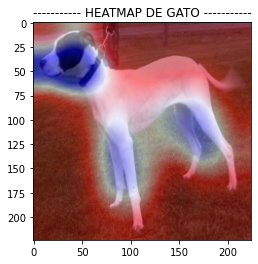

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


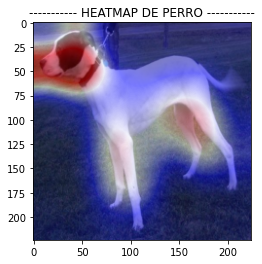

PROB CAM:
	- GATO: 0.00000
	- PERRO: 1.00000
(CLASS PREDICTED -- perro) vs (perro -- ACTUAL CLASS)
########################################################
########################################################
########################################################


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([7, 7])
torch.Size([7, 7])


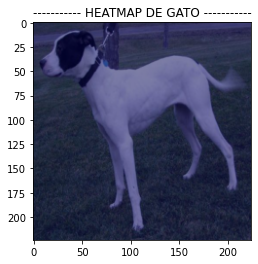

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


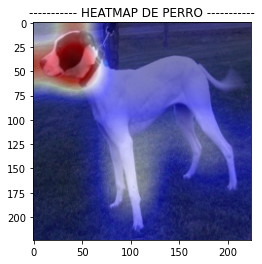

PROB GradCAM:
	- GATO: 0.00000
	- PERRO: 1.00000
(CLASS PREDICTED -- perro) vs (perro -- ACTUAL CLASS)
########################################################
########################################################
########################################################


RuntimeError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 8.00 GiB total capacity; 5.20 GiB already allocated; 0 bytes free; 5.62 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [24]:
# Cogemos la activación de las capas
x, act_classes=next(iter(dataloader_test))
x=x.to(device)

mean = [0.485, 0.456, 0.406]
var = [0.229, 0.224, 0.225]
x_plot=((torch.reshape(x.cpu(), (3,224,224)).permute(1,2,0).numpy())*var)+mean

act_classes=act_classes.to(device)

actual_y = "gato" if act_classes[0]==0 else "perro"
print(actual_y)

model_cam.plot_saliency_map(x, act_classes[0], -2)

print("########################################################")
print("########################################################")
print("########################################################")

model_gradcam.plot_saliency_map(x, act_classes[0], -2)

print("########################################################")
print("########################################################")
print("########################################################")

model_gradcampp.plot_saliency_map(x, act_classes[0], -2)


In [ ]:
a = torch.tensor()
a=torch.reshape(a,(2,2,3)).float()
print(a.shape)
b = torch.tensor([1,2,3]).float()
c = torch.matmul(a,b)

print(c)

In [ ]:
# Cogemos la activación de las capas
x, classes=next(iter(dataloader_test))
x=x.to(device)
classes=classes.to(device)

soft = nn.Softmax(dim=1)

# CAM
model_conv.eval()
y_pred_cam = torch.argmax(soft(model_conv(x)),axis=1)

activacion = model_conv.features(x)
act_shape = activacion.shape
activacion = torch.reshape(activacion, (act_shape[1],act_shape[2],act_shape[3]))

heatmap_gato = torch.zeros((activacion.shape[1],activacion.shape[2])).to(device)
heatmap_perro = torch.zeros((activacion.shape[1],activacion.shape[2])).to(device)

for p in model_conv.fc.parameters():
  for i in range(activacion.shape[0]):
    heatmap_gato = heatmap_gato + activacion[i]*p[0][i]
    heatmap_perro = heatmap_perro + activacion[i]*p[1][i]

# Normalizamos
"""
maximo_ambos = max(torch.max(heatmap_gato), torch.max(heatmap_perro))
minimo_ambos = min(torch.min(heatmap_gato), torch.min(heatmap_perro))
print(f"MAXIMO: {maximo_ambos}")
print(f"MINIMO: {minimo_ambos}")

heatmap_gato = (heatmap_gato-minimo_ambos)/(abs(maximo_ambos-minimo_ambos))
heatmap_perro = (heatmap_perro-minimo_ambos)/(abs(maximo_ambos-minimo_ambos))
"""
print(heatmap_perro.size())

###############################################################################
# Grad-CAM
model_conv_grad.to(device)
model_conv_grad.eval()

y_pred_grad= torch.argmax(soft(model_conv_grad(x)),axis=1)


grad_activation = model_conv_grad.avgPool(model_conv_grad.features(x)) # tiene le requires_grad=True
grad_act_shape = grad_activation.shape
grad_activation =  torch.reshape(grad_activation, (1, grad_act_shape[1]*grad_act_shape[2]*grad_act_shape[3]))


grad_activation.retain_grad() # Enables this Tensor to have their grad populated during backward().
Y_grad = model_conv_grad.fc(model_conv_grad.classifier(grad_activation))
#torch.autograd.backward([Y_grad[0][0], Y_grad[0][1]])

Y_grad = torch.autograd.backward(Y_grad[0][y_pred_grad[0]])
pesos_alpha = []
for n in range(grad_act_shape[1]):
  peso_aux = 0
  for i in range(grad_act_shape[2]):
    for j in range(grad_act_shape[3]):
      peso_aux = peso_aux + grad_activation.grad[0][n*grad_act_shape[2]*grad_act_shape[3]+i*grad_act_shape[3]+j]

  pesos_alpha.append(peso_aux/float(grad_act_shape[2]*grad_act_shape[3]))


print(f"PESOS_ALPHA: {len(pesos_alpha)}, max:{max(pesos_alpha)}, min:{min(pesos_alpha)}")
pesos_alpha_tensor = torch.tensor(pesos_alpha).to(device)

activacion_final_grad = torch.zeros((grad_act_shape[2], grad_act_shape[3])).to(device)
for n in range(len(pesos_alpha)):
  ini = n*grad_act_shape[2]*grad_act_shape[3]
  fin = (n+1)*grad_act_shape[2]*grad_act_shape[3]
  aux = torch.reshape(grad_activation[0][ini:fin], (grad_act_shape[2],grad_act_shape[3]))
  activacion_final_grad = activacion_final_grad + pesos_alpha_tensor[n]*aux

relu = nn.ReLU()
heatmap_grad=relu(activacion_final_grad)
print(heatmap_grad.shape)

###############################################################################
# Comprobación gradcam
model_conv.to(device)
model_conv.eval()

y_pred_grad_comprobacion = torch.argmax(soft(model_conv(x)),axis=1)


grad_activation_comprobacion = model_conv.features(x) # tiene le requires_grad=True
grad_act_shape_comprobacion = grad_activation_comprobacion.shape


grad_activation_comprobacion.retain_grad() # Enables this Tensor to have their grad populated during backward().
aux = model_conv.avgPool(grad_activation_comprobacion)
aux_shape_comprobacion = aux.shape
aux =  torch.reshape(aux, (1, aux_shape_comprobacion[1]*aux_shape_comprobacion[2]*aux_shape_comprobacion[3]))

Y_grad_comprobacion = model_conv.fc(aux)
#torch.autograd.backward([Y_grad[0][0], Y_grad[0][1]])


Y_grad_comprobacion = torch.autograd.backward(Y_grad_comprobacion[0][y_pred_grad_comprobacion[0]])

pesos_alpha_comprobacion = []
# PROBAR:
# torch.mean(input= grad_activation_comprobacion.grad[0], dim=(1,2), keepdim=False, *, dtype=None, out=None)
for n in range(grad_act_shape_comprobacion[1]):
  peso_aux = 0
  for i in range(grad_act_shape_comprobacion[2]):
    for j in range(grad_act_shape_comprobacion[3]):
      peso_aux = peso_aux + grad_activation_comprobacion.grad[0][n][i][j]

  pesos_alpha_comprobacion.append(peso_aux/float(grad_act_shape_comprobacion[2]*grad_act_shape_comprobacion[3]))


print(f"PESOS_ALPHA: {len(pesos_alpha_comprobacion)}, max:{max(pesos_alpha_comprobacion)}, min:{min(pesos_alpha_comprobacion)}")
pesos_alpha_tensor_comprobacion = torch.tensor(pesos_alpha_comprobacion).to(device)

activacion_final_grad_comprobacion = torch.zeros((grad_act_shape_comprobacion[2], grad_act_shape_comprobacion[3])).to(device)
for n in range(len(pesos_alpha_comprobacion)):
 activacion_final_grad_comprobacion = activacion_final_grad_comprobacion + grad_activation_comprobacion[0][n]*pesos_alpha_comprobacion[n]

relu = nn.ReLU()
heatmap_grad_comprobacion=(activacion_final_grad_comprobacion)
print(heatmap_grad_comprobacion.shape)

###########################
#
#   HACEMOS PLOT
#
##########################
# CAM
x_plot=torch.reshape(x.cpu(), (3,224,224)).permute(1,2,0).numpy()
hm_g = heatmap_gato.cpu().detach().numpy()
hm_d = heatmap_perro.cpu().detach().numpy()
hm_grad = heatmap_grad.cpu().detach().numpy()
hm_grad_comprobacion = heatmap_grad_comprobacion.cpu().detach().numpy()

aux1=hm_grad_comprobacion*49
aux2=hm_g
aux3=hm_d
"""
aux1=(hm_grad_comprobacion-np.amin(hm_grad_comprobacion))
aux1 = aux1/np.amax(aux1)

aux2=(hm_d-np.amin(hm_d))
aux2= aux2/np.amax(aux2)

aux3=(hm_g-np.amin(hm_g))
aux3=aux3/np.amax(aux3)
"""
print(f'1.- min: {np.amin(aux1)}, max: {np.amax(aux1)}')
print(f'2.- min: {np.amin(aux2)}, max: {np.amax(aux2)}')
print(f'3.- min: {np.amin(aux3)}, max: {np.amax(aux3)}')
min_dist = min([np.linalg.norm(aux1-aux2), np.linalg.norm(aux1-aux3)])
print(f'dist: {min_dist}')


if (aux1==aux2).all() or (aux1==aux3).all():
  print("SON IGUALES!!!!")
else:
  print("Pues no son igualesxd")


fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].imshow(aux3) #gato
axes[1].imshow(aux1) #gradcam
axes[2].imshow(aux2) #perro

plt.show()


fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(aux3-aux1) #gato
axes[1].imshow(aux2-aux1) #perro

plt.show()

resg = cv2.resize(hm_g*225, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
resd = cv2.resize(hm_d*225, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
resgrad = cv2.resize(hm_grad*225, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
resgrad_comprobacion = cv2.resize(hm_grad_comprobacion*225, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)


plt.imshow(x_plot)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=3)


print(f"CAM:{y_pred_cam[0]}")
cam_pred_name = "gato" if y_pred_cam[0]==0 else "perro"
print(f"Grad-CAM:{y_pred_grad[0]}")
gradcam_pred_name = "gato" if y_pred_grad[0]==0 else "perro"
gradcam_pred_name_comprobacion = "gato" if y_pred_grad_comprobacion[0]==0 else "perro"

if classes[0]==0:
  print("----------- ES UN GATO -----------")
    
  axes[0].imshow(x_plot)
  axes[0].imshow(resgrad,alpha=0.5, cmap=plt.get_cmap('seismic'))
  axes[0].title.set_text(f"GRAD-CAM ({gradcam_pred_name})")

  axes[1].imshow(x_plot)
  axes[1].imshow(resg,alpha=0.5, cmap=plt.get_cmap('seismic'))
  axes[1].title.set_text(f"CAM ({cam_pred_name})")
  
  axes[2].imshow(x_plot)
  axes[2].imshow(resgrad_comprobacion,alpha=0.5, cmap=plt.get_cmap('seismic'))
  axes[2].title.set_text(f"CAM-COMPROB ({gradcam_pred_name_comprobacion})")
  plt.show()

else:
  print("----------- ES UN PERRO -----------")

  axes[0].imshow(x_plot)
  axes[0].imshow(resgrad,alpha=0.5, cmap=plt.get_cmap('seismic'))
  axes[0].title.set_text(f"GRAD-CAM ({gradcam_pred_name})")

  axes[1].imshow(x_plot)
  axes[1].imshow(resd,alpha=0.5, cmap=plt.get_cmap('seismic'))
  axes[1].title.set_text(f"CAM ({cam_pred_name})")
  
  axes[2].imshow(x_plot)
  axes[2].imshow(resgrad_comprobacion,alpha=0.5, cmap=plt.get_cmap('seismic'))
  axes[2].title.set_text(f"GRADCAM-COMPROB ({gradcam_pred_name_comprobacion})")
  plt.show()


print(f"c={classes}")
print(f"PREDICCIÓN CAM: {soft(model_conv(x))}")
print(f"PREDICCIÓN GRADCAM: {soft(model_conv_grad(x))}")



In [ ]:
i=-1
x, classes=next(iter(dataloader_test))
x = x.to(device)

def remove_modules_type(module, type_module):
  """
  Parameters:
  -----------
    module: nn.Module
      Module where we want to remove {type_module} modules.
    
    type_module: class which inherits from nn.Module
      Type to remove.

    Description:
    ------------
      This function remove all {type_module} modules from
      a first module: {module}
  """
  hay_fc = False
  mod_without_type = []
  for m in module.children():
    if isinstance(m, type_module):
      hay_fc = True
    elif isinstance(m, nn.Sequential) and not(isinstance, VGG16_CAM):
      mod_without_type.append(nn.Sequential(*remove_modules_type(m, nn.Linear)))
    else:
      mod_without_type.append(m)

    # Si hay fc terminamos
    if hay_fc:
      return mod_without_type

  return mod_without_type

print(model_conv)


## PRUEBA GRADIENTES

In [ ]:
t1=torch.tensor(1., requires_grad=True)
t2=torch.tensor(2., requires_grad=True)
t3=torch.tensor(3., requires_grad=True)
################################################

t4 = t1+t2
t5=t4*t3

t5.backward()
print(t3.grad)
################################################

t1.grad=torch.zeros_like(t1)
t2.grad=torch.zeros_like(t2)
t3.grad=torch.zeros_like(t3)

t6= (t3+t1)
t7= t6*t2

t7.backward()
print(t3.grad)

##############################################
prueba = torch.tensor([[[1,1,1],[2,2,2],[3,3,3]], [[4,4,4],[5,5,5],[6,6,6]], [[7,7,7],[8,8,8],[9,9,9]]])

prueba2= torch.sum(prueba,(0))
print(prueba[:,None,None].shape)
print(prueba[:,:,:].shape)
##############################################
input = torch.tensor([[1.,2.],[3.,4.],[5.,6.]], requires_grad=True)
x1 = torch.tensor([[2.,2.],[-0.5,-1.]], requires_grad=True)
x2 = torch.tensor([[0.5],[-1.5]], requires_grad=True)

input.retain_grad()

aux =torch.matmul(input,x1)
y =  torch.exp(torch.matmul(aux,x2))
print(y)

y[0][0].backward(create_graph=True)
print(input.grad)

aux = input.grad[0][0]

input.grad.data.zero_()

aux.backward(create_graph=True)
print(input.grad)
print("=====================================")


first_derivative = torch.autograd.grad(y[0][0], input, create_graph=True)[0]
# We now have dloss/dx
first_derivative.backward(create_graph=True)
second_derivative = torch.autograd.grad(first_derivative[0][0], input)[0]
# This computes d/dx(dloss/dx) = d2loss/dx2

print(input.grad)
